# Cars Dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import random
import scipy
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
import time
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn import Identity
from torchvision.io import read_image
from torchvision import transforms
import torch
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

## Data

The dataset should (be downloaded)[https://ai.stanford.edu/~jkrause/cars/car_dataset.html] and extracted into a `data/` folder at the project root.  

In [2]:
DATA_PATH = Path("data")

### TASK 1 - Build a function that converts a labelled dataset into labelled and unlabelled subsets.

In [82]:
def get_labelled_and_unlabelled_indexes(
    dataset_labels,
    proportion
):
    if 0 >= proportion >= 1:
        raise ValueError("`proportion` should be a float between 0 and 1.")

    split_index = int(len(dataset_labels) * (1 - proportion))
    unique_classes = np.unique(dataset_labels).tolist()
    
    if split_index < len(unique_classes):
        min_proportion = len(unique_classes) / len(dataset_labels)
        raise ValueError(
            f"The proportion should be greater than {min_proportion} to ensure" \
            "all unique classes have at least one instance labelled."
        )
        
    dataset_indexes = np.arange(0, len(dataset_labels))
    
    while True:
        random.shuffle(dataset_indexes)
    
        labelled_indexes = dataset_indexes[:split_index]
        unlabelled_indexes = dataset_indexes[split_index:]
    
        # Make sure at least one instance of each class is labelled
        if np.unique(np.array(dataset_labels)[labelled_indexes]).tolist() == unique_classes:
            break
    
    return labelled_indexes, unlabelled_indexes 

### TASK 2 - Data cleaning

In [116]:
def delete_non_RGB_images(image_path):
    delete_count = 0
    for filename in image_path.iterdir():
        image = Image.open(filename)
        if image.mode == "RGB":
            continue
            
        print(f"Deleting {filename} (is not an RGB image).")
        filename.unlink()
        delete_count += 1

    print(f">>> Deleted {delete_count} files in {image_path}.")

    
for image_path in [
    DATA_PATH / "cars_train", 
    DATA_PATH / "cars_test", 
]:
    delete_non_RGB_images(image_path)

Deleting data/cars_train/05713.jpg (is not an RGB image).
Deleting data/cars_train/03439.jpg (is not an RGB image).
Deleting data/cars_train/08144.jpg (is not an RGB image).
Deleting data/cars_train/05502.jpg (is not an RGB image).
Deleting data/cars_train/04848.jpg (is not an RGB image).
Deleting data/cars_train/03048.jpg (is not an RGB image).
Deleting data/cars_train/03539.jpg (is not an RGB image).
Deleting data/cars_train/07774.jpg (is not an RGB image).
Deleting data/cars_train/05177.jpg (is not an RGB image).
Deleting data/cars_train/08137.jpg (is not an RGB image).
Deleting data/cars_train/02176.jpg (is not an RGB image).
Deleting data/cars_train/01085.jpg (is not an RGB image).
Deleting data/cars_train/07383.jpg (is not an RGB image).
Deleting data/cars_train/03469.jpg (is not an RGB image).
Deleting data/cars_train/06947.jpg (is not an RGB image).
Deleting data/cars_train/00266.jpg (is not an RGB image).
Deleting data/cars_train/04577.jpg (is not an RGB image).
Deleting data/

### TASK 3 - Dataset representation

In [117]:
def load_images(image_path):
    images = {}
    for filename in image_path.iterdir():
        # Directly load images as tensors
        images[filename.name] = read_image(str(filename))
    
    print(f"{len(images)} images in {image_path}.")
    
    return images    

train_images = load_images(DATA_PATH / "cars_train")

8126 images in data/cars_train.


In [118]:
def load_annotation_files(filename):
    data = scipy.io.loadmat(filename)["annotations"][0]
    
    annotations = {}
    for d in data:
        image_filename = d[-1][0]
        _class = d[-2][0][0]
        
        annotations[image_filename] = _class
    
    return annotations
        
train_annotations = load_annotation_files(DATA_PATH / "devkit" / "cars_train_annos.mat")

In [119]:
def prepare_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    # Replace last layer
    model.fc = Identity()
    
    return model.eval()

model = prepare_model()

In [9]:
def prepare_dataset(model, transform, images, annotations):
    dataset = {}
    for i, (image_filename, image) in enumerate(tqdm(images.items())):
        if image_filename not in annotations:
            print(image_filename)
            continue
        
        x = image / 256
        x = transform(x)
        x = x.float()
        x = x.unsqueeze(0)
        
        embedding = model(x).detach()
        embedding = embedding[0].numpy()
        
        dataset[i] = {
            "embedding": embedding, 
            "class_idx": annotations[image_filename], 
            "labelled": True
        }
        
    return dataset
    
dataset = prepare_dataset(
    model=model, 
    transform=ResNet18_Weights.DEFAULT.transforms(), 
    images=train_images, 
    annotations=train_annotations
)
torch.save(dataset, DATA_PATH / "dataset.pt")

# dataset = torch.load(DATA_PATH / "dataset.pt")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8126/8126 [02:15<00:00, 59.92it/s]


### TASK 4 - Build a partially labelled dataset

In [120]:
dataset_inputs, dataset_labels = zip(*[
    (d["embedding"], d["class_idx"]) for d in dataset.values()
])
    
labelled_indexes, unlabelled_indexes = get_labelled_and_unlabelled_indexes(
    dataset_labels,
    0.6
)

print(f"{len(labelled_indexes)} labelled items ({round(len(labelled_indexes) / len(dataset_labels) * 100)})%")
print(f"{len(unlabelled_indexes)} unlabelled items ({round(len(unlabelled_indexes) / len(dataset_labels) * 100)})%")

3250 labelled items (40)%
4876 unlabelled items (60)%


### TASK 5 - Create train/validation split

In [121]:
def split_dataset(
    dataset_inputs,
    dataset_labels,
    training_proportion
):
    if 0 >= training_proportion >= 1:
        raise ValueError("`training_proportion` should be a float between 0 and 1.")
    
    index_split = int(len(dataset_inputs) * training_proportion)
    
    training_inputs = dataset_inputs[:index_split]
    training_labels = dataset_labels[:index_split]
    
    valid_inputs = dataset_inputs[index_split:]
    valid_labels = dataset_labels[index_split:]
    
    return training_inputs, training_labels, valid_inputs, valid_labels

### TASK 6 - Create experiment(s) to convince clients that more labelled data will improve model performance 

In [157]:
def select_items(my_list, selected_indexes):
    selected_items = [
        item for i, item in enumerate(my_list) if i in selected_indexes
    ]
    
    return selected_items

def train_model(X_train, y_train, X_valid, y_valid, max_iteration=1000, verbose=0):
    classifier = make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss="modified_huber", 
            max_iter=max_iteration,  
            tol=5e-4, 
            penalty="l2", 
            verbose=verbose, 
            random_state=1
        )
    )
    
    t0 = time.time()
    classifier.fit(X_train, y_train)
    t1 = time.time()
    
    print(f"Classifier trained in {round(t1 - t0, 2)} seconds.")
    
    train_score = classifier.score(X_train, y_train)
    valid_score = classifier.score(X_valid, y_valid)
    
    return classifier, train_score, valid_score

dataset_inputs_labelled = select_items(dataset_inputs, labelled_indexes)
dataset_labels_labelled = select_items(dataset_labels, labelled_indexes)

X_train, y_train, X_valid, y_valid = split_dataset(
    dataset_inputs_labelled,
    dataset_labels_labelled,
    training_proportion=0.8
)

print(f"Train: {len(X_train)} samples ({round(len(X_train) / len(dataset_inputs) * 100)}% original dataset)")
print(f"Valid: {len(X_valid)} samples ({round(len(X_valid) / len(dataset_inputs) * 100)}% original dataset)\n")

classifier, train_score, valid_score = train_model(
    X_train, 
    y_train, 
    X_valid, 
    y_valid, 
    max_iteration=10000, 
    verbose=0
)
print(f"\nTraining score: {round(train_score, 3)}")
print(f"Validation score: {round(valid_score, 3)}")

Train: 2600 samples (32% original dataset)
Valid: 650 samples (8% original dataset)

Classifier trained in 7.81 seconds.

Training score: 0.974
Validation score: 0.185


Here, we try to select the most important features based on the variance accross the whole dataset. The hyposthesis is that the resnet18 embedding may have useless features to describe different type of cars since they are most likely similar in the embedding space. We try to reduce the input dimension so that the model can focus on relevent features. 

Unfortunately, this solution does not seem to be efficient here, since the validation score is even lower. 

In [158]:
minimal_variance = 0.1

features_variance = np.var(dataset_inputs, axis=0)
most_import_features_index = np.where(features_variance > minimal_variance)[0]
print(f"Selected {len(most_import_features_index)}/{len(features_variance)} features.")

X_train_reduced = [x[most_import_features_index] for x in X_train]
X_valid_reduced = [x[most_import_features_index] for x in X_valid]

classifier, train_score, valid_score = train_model(
    X_train_reduced, 
    y_train, 
    X_valid_reduced, 
    y_valid, 
    max_iteration=10000, 
    verbose=0
)
print(f"\nTraining score: {round(train_score, 3)}")
print(f"Validation score: {round(valid_score, 3)}")

Selected 458/512 features.
Classifier trained in 7.13 seconds.

Training score: 0.967
Validation score: 0.183


In [159]:
train_scores = []
valid_scores = []

train_sizes = [
    int(ratio * len(X_train)) for ratio in np.arange(0.2, 1, 0.2)
]

for n in train_sizes:
    classifier, train_score, valid_score = train_model(
        X_train[:n], 
        y_train[:n], 
        X_valid, 
        y_valid, 
        max_iteration=10000, 
        verbose=0
    )
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)

Classifier trained in 0.66 seconds.
Classifier trained in 1.6 seconds.
Classifier trained in 3.12 seconds.
Classifier trained in 4.99 seconds.


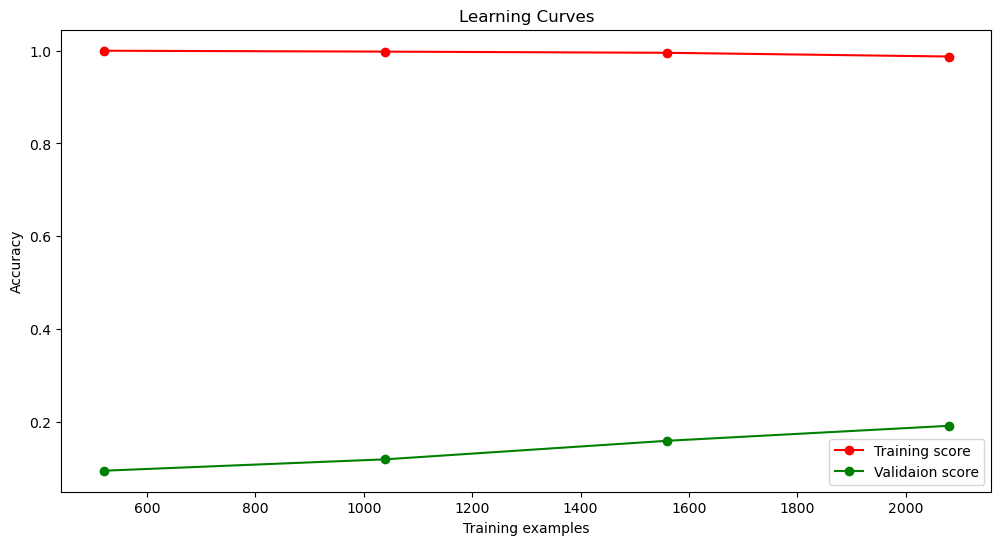

In [160]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    train_sizes, 
    train_scores, 
    label="Training score",
    marker="o", 
    color="r"
)
ax.plot(
    train_sizes, 
    valid_scores, 
    label="Validaion score", 
    marker="o", 
    color="g"
)
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.set_title("Learning Curves")
ax.legend(loc="best")

Here, we present our classifiers learning curves. More specifically, we observe the training (red) and validation (green) scores with an increasing number of training samples. Here, the training score curve shows that the classifier can effectively learn features from the training set. However, we observe a big gap between the training and validation curve. That gap indicates that the model is unable to generalize to unseen data. Still, we note that the validation score is increasing with additional training data. 

This leads us to think that more data would help the model perform better. 

### TASK 7 - Active learning to select new instances to be labelled

In [161]:
X_candidates = select_items(dataset_inputs, unlabelled_indexes)
y_candidates = select_items(dataset_labels, unlabelled_indexes)

K_candidates = int(len(dataset_inputs) * 0.25)

probabilities = classifier.predict_proba(X_candidates)
entropies = scipy.stats.entropy(probabilities, axis=1)

selected_candidate_indexes = np.argsort(entropies).tolist()[-K_candidates:]

print(f"Selected {K_candidates} samples ({round(K_candidates / len(dataset_inputs) * 100)}% original dataset)")

Selected 2031 samples (25% original dataset)


In active learning, the goal is to select the most uncertain samples to be labelled. Here, we define the uncertainty as the entropy of the predition probability. If the the probability prediction have a high entropy, it means that the model is confused. 

Here, we directly selected the K candidates where the entropy was the highest. We could have done it iteratively, ie that we gradually label more data, retrain the classifier, and select new candidates based on the entropy.

### TASK 8 - Final model training and evaluation

In [162]:
X_extra = select_items(dataset_inputs, selected_candidate_indexes)
y_extra = select_items(dataset_labels, selected_candidate_indexes)

X_final = X_train + X_extra
y_final = y_train + y_extra

print(f"Train: {len(X_final)} samples ({round(len(X_final) / len(dataset_inputs) * 100)}% original dataset)")
print(f"Valid: {len(X_valid)} samples ({round(len(X_valid) / len(dataset_inputs) * 100)}% original dataset)\n")

classifier.fit(X_final, y_final)

# We want our validation set to remain the same
valid_score = classifier.score(X_valid, y_valid)

print(f"FINAL VALID SCORE {round(valid_score, 3)}")

Train: 4631 samples (57% original dataset)
Valid: 650 samples (8% original dataset)

FINAL VALID SCORE 0.226


The final performance of our model is 23% of accuracy. 

For any application, this level of performance is considered extremely poor. As as a result, we think that the decision to label more data was not a good one. 

However, this final score was to be expected. In fact, given the poor performance with 40% of the data labelled (more or less 0.2 accuracy), it is no surprise that labelling 25% more of the original dataset helped improve the performance, but not did not bring it to a satisfactory level.


TODO: explain your solution